In [1]:
# Stroke analysis
from statsmodels.genmod import families
from statsmodels.genmod.generalized_linear_model import GLM
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import xgboost as xgb
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


## Dataset

In [2]:
df = pd.read_csv("/kaggle/input/stroke/data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The dataset includes 5110 records of 5110 cases, 1 `id`, 10 demographic and health indices, and 1 column indicating whether or not the patient had a stroke. <br> The column `id` does not play a role in predicting stroke, so it should be removed.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are 3 numerical factors: `age`,`avg_glucose_level` and `bmi`. <br>
The others are categorical. However, these variables types need to be adjusted. Some are noted as "int64," while others are "object" type. This problem is solved by converting to category type.


In [4]:
df["stroke"].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

It is an imbalanced dataset which contains fewer positive cases.

## Pre-processing data

In this step, the dataset is cleaned, checked NAN, checked duplicates and inspected further inside each feature.

### Drop redundant features



In [5]:
df = df.drop ("id",axis =1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The `id` column is dropped.

### Check NA values

In [6]:
# Check NA
df.isna().sum()
print(' ')
print('%s NA values in positive cases' % df[df['bmi'].isna() & df['stroke'] == 1].shape[0])
# Fill NA
df['bmi'].fillna(np.round(df['bmi'].mean(), 1), inplace = True)

 
40 NA values in positive cases


There are 201 NA values in the `bmi` column, including 40 positive cases without `bmi` index. <br> The NA problem is solved by filling with the mean value rather than deleting it due to the data imbalance with fewer positive cases.


In [7]:
# Check duplicates
dupli_sum = df.duplicated().sum()
if (dupli_sum>0):
    df = df.loc[False==df.duplicated(), :]
    print("Removed %s duplicates" % dupli_sum)
else:
    print("No duplicates found")

No duplicates found


No duplicates are found in the dataset.

### Inspect categorical variables

In [8]:
for i in [
    "gender",
    "work_type",
    "ever_married",
    "residence_type",
    "smoking_status",
    'stroke',
    'hypertension',
    'heart_disease'
    ]:
    print("---- %s ----" % i)
    print(df[i].value_counts())

---- gender ----
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
---- work_type ----
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
---- ever_married ----
Yes    3353
No     1757
Name: ever_married, dtype: int64
---- residence_type ----
Urban    2596
Rural    2514
Name: residence_type, dtype: int64
---- smoking_status ----
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64
---- stroke ----
0    4861
1     249
Name: stroke, dtype: int64
---- hypertension ----
0    4612
1     498
Name: hypertension, dtype: int64
---- heart_disease ----
0    4834
1     276
Name: heart_disease, dtype: int64


In gender, the other category just has one record, which is not significant for the analysis, so it is eliminated. Moreover, as mentioned above, all categorical variables have "object" type which need to change into a "category" type as well.


In [9]:
# Drop "Other" rows in gender
df = df[df["gender"] != "Other"]

# Change columns type
for i in [
    "gender",
    "work_type",
    "ever_married",
    "residence_type",
    "smoking_status",
    'stroke',
    'hypertension',
    'heart_disease'
]:
    df[i] = df[i].astype('category')

### Inspect numerical variables

In [10]:
for i in ["age","avg_glucose_level","bmi"]:
    print("-- %s --" % i)
    print(df[i].describe())

-- age --
count    5109.000000
mean       43.229986
std        22.613575
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64
-- avg_glucose_level --
count    5109.000000
mean      106.140399
std        45.285004
min        55.120000
25%        77.240000
50%        91.880000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64
-- bmi --
count    5109.000000
mean       28.894774
std         7.698235
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64


These variables have different scales. <br>

Grouping into bins for visualisation purposes.

In [11]:
# Create bins
df['age_binned'] = pd.cut(df['age'], np.arange(0, 91, 5))
df['avg_glucose_level_binned'] = pd.cut(df['avg_glucose_level'], np.arange(0, 301, 10))
df['bmi_binned'] = pd.cut(df['bmi'], np.arange(0, 101, 5))

#Final table
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_binned,avg_glucose_level_binned,bmi_binned
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,"(65, 70]","(220, 230]","(35, 40]"
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.9,never smoked,1,"(60, 65]","(200, 210]","(25, 30]"
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,"(75, 80]","(100, 110]","(30, 35]"
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,"(45, 50]","(170, 180]","(30, 35]"
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,"(75, 80]","(170, 180]","(20, 25]"


## EDA

### Encode data

For continuous variables, using min-max scaling to convert all these data into the same scales [0,1].

In [12]:
# Min-max scaler
for i in ["age","avg_glucose_level","bmi"]:
    df[i+"_norm"] = (df[i]-df[i].min())/(df[i].max()-df[i].min())
    df[i+"_norm"].describe()

df.head()  

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_binned,avg_glucose_level_binned,bmi_binned,age_norm,avg_glucose_level_norm,bmi_norm
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,"(65, 70]","(220, 230]","(35, 40]",0.816895,0.801265,0.301260
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.9,never smoked,1,"(60, 65]","(200, 210]","(25, 30]",0.743652,0.679023,0.213058
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,"(75, 80]","(100, 110]","(30, 35]",0.975586,0.234512,0.254296
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,"(45, 50]","(170, 180]","(30, 35]",0.597168,0.536008,0.276060
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,"(75, 80]","(170, 180]","(20, 25]",0.963379,0.549349,0.156930


For categorical variables, use a dummy encoder to convert the category into dummies and drop one of the dummies to avoid the dummy trap (perfect multicollinearity).

In [13]:
# Create dummies
dummies = pd.get_dummies(df[["gender", "work_type", "ever_married", "residence_type","smoking_status","hypertension","heart_disease"]])
                      
dummies = dummies.drop([
    "gender_Male",
    "work_type_children",
    'ever_married_No',
    'residence_type_Urban',
    "smoking_status_Unknown",
    "hypertension_0",
    "heart_disease_0"
], axis=1)

dummies.head()

,gender_Female,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,ever_married_Yes,residence_type_Rural,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,hypertension_1,heart_disease_1
0,0,0,0,1,0,1,0,1,0,0,0,1
1,1,0,0,0,1,1,1,0,1,0,0,0
2,0,0,0,1,0,1,1,0,1,0,0,1
3,1,0,0,1,0,1,0,0,0,1,0,0
4,1,0,0,0,1,1,1,0,1,0,1,0


Concat encoded columns and dummies into X (independent variables) and y (dependent variable )

In [14]:
X = pd.concat([df[["age_norm","avg_glucose_level_norm","bmi_norm"]],dummies],axis=1)
y = df["stroke"]

print ('---- Independent factors------')
print(X.head())

print ('---- Dependent factors------')
print(y)

---- Independent factors------
   age_norm  avg_glucose_level_norm  bmi_norm  gender_Female  \
0  0.816895                0.801265  0.301260              0   
1  0.743652                0.679023  0.213058              1   
2  0.975586                0.234512  0.254296              0   
3  0.597168                0.536008  0.276060              1   
4  0.963379                0.549349  0.156930              1   

   work_type_Govt_job  work_type_Never_worked  work_type_Private  \
0                   0                       0                  1   
1                   0                       0                  0   
2                   0                       0                  1   
3                   0                       0                  1   
4                   0                       0                  0   

   work_type_Self-employed  ever_married_Yes  residence_type_Rural  \
0                        0                 1                     0   
1                        1         

### Correlation among X

Plotting a heat map to show correlations between independent features.


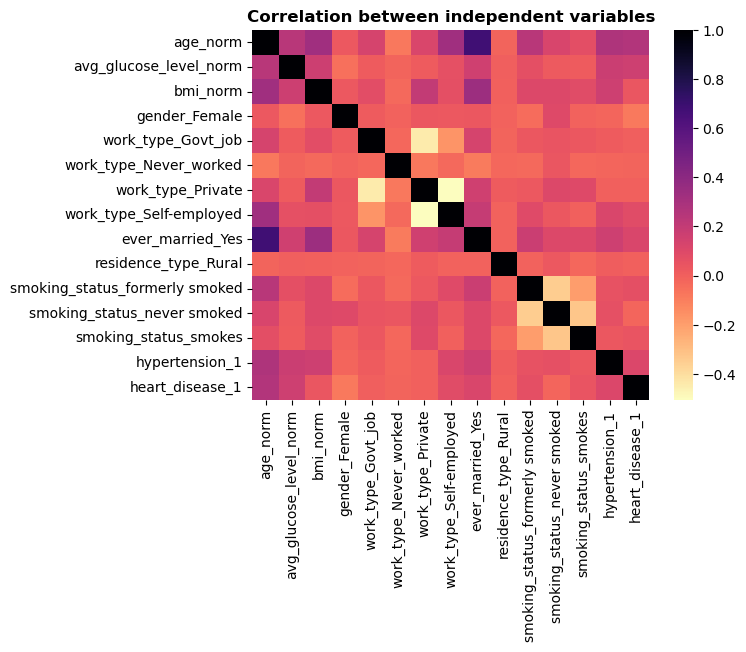

In [15]:
# Heat map correlation
cor_matrix = round(X.corr(), 3)
sns.heatmap(
    cor_matrix,
    cmap="magma_r")
plt.title("Correlation between independent variables", fontweight='bold')
plt.show()

There are many insights derived from the heatmap by noticing high positive (for positive relations) and high negative numbers (for inverse relations) between different variables.

-   Most inverse correlations come from dummies of variables due to trade-offs.

-   Ages have some noticed correlations. One obvious relation is between `age` & `ever_married_Yes`. Married persons are adults. Old people tend to have their own businesses and quit smoking.

-   3 numerical variables have positive relations. `bmi` and `avg_glucose_level` increase when people get old. There is a positive relation between `avg_glucose_level` and `bmi` but not strong as the relations with age.

-   Married persons often have high `bmi` and glucose levels. They have jobs and have been working.

-   `gender` and `residence_type` do not show any significance related to variables.

The Pearson correlation works for pairs of variables, so for further checking correlation, the VIF metric is adopted to understand the correlation of a variable with multiple others.


In [16]:
#VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
## calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

                           feature        VIF
0                         age_norm  13.111282
1           avg_glucose_level_norm   2.415785
2                         bmi_norm   7.518883
3                    gender_Female   2.272366
4               work_type_Govt_job   3.387468
5           work_type_Never_worked   1.034035
6                work_type_Private  10.388061
7          work_type_Self-employed   4.416993
8                 ever_married_Yes   5.709542
9             residence_type_Rural   1.813306
10  smoking_status_formerly smoked   1.934309
11     smoking_status_never smoked   2.849732
12           smoking_status_smokes   1.811474
13                  hypertension_1   1.228722
14                 heart_disease_1   1.177817


It shows the same pattern with the correlation heatmap.

### Explore the relations between X and y

Four functions are defined to generate a frequency chart, a percentage chart, a boxplot (for numeric only) and a function to combine 3 charts for convenience.


In [17]:
# Define visualisation functions
def get_bar_chart(column, width=1, stacked=False):
    # Get the count of records by column and stroke
    df_pct = df.groupby([column, 'stroke'])['age'].count()
    # Create proper DataFrame's format
    df_pct = df_pct.unstack()
    return df_pct.plot.bar(
        stacked=stacked,
        figsize=(15, 5),
        width=width,
        ax=ax1,
        legend=False
    )

def get_100_percent_stacked_bar_chart(column, width=0.5):
    # Get the count of records by column and stroke
    df_breakdown = df.groupby([column, 'stroke'])['age'].count()
    # Get the count of records by gender
    df_total = df.groupby([column])['age'].count()
    # Get the percentage for 100% stacked bar chart
    df_pct = df_breakdown / df_total * 100
    # Create proper DataFrame's format
    df_pct = df_pct.unstack()
    return df_pct.plot.bar(
        stacked=True,
        figsize=(15,5),
        width=width,
        ax=ax2,
        legend=False
    )

def get_boxplot_chart(column):
    # Get boxplot chart for continuos variables
    return sns.boxplot(
        data=df,
        x='stroke',
        y=column,
        ax=ax3
    )

def get_charts(column, type="numerical"):
    # Check the variables type
    if type not in ["numerical", "categorical"]:
        print("Please choose variable type numerical or categorical")
        return
    # Declare plot variables
    global fig, ax1, ax2, ax3
    # Plot numerical variable
    if type == "numerical":
        ori = "_".join(column.split("_")[:-1])
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
        ax1 = get_bar_chart(column, width=0.9)
        ax2 = get_100_percent_stacked_bar_chart(column, width=0.9)
        ax3 = get_boxplot_chart(ori)
    # Plot category
    if type == "categorical":
        fig, (ax1, ax2) = plt.subplots(ncols=2)
        ax1 = get_bar_chart(column, width=0.9)
        ax2 = get_100_percent_stacked_bar_chart(column, width=0.9)
    # Setup same formating parameter
    ax1.set_ylabel("frequency")
    ax2.set_ylabel("percentage")
    fig.legend(
        ["no stroke", "stroke"],
        loc="upper center",
        ncol = 2
    )

Getting visualations of continuous values.

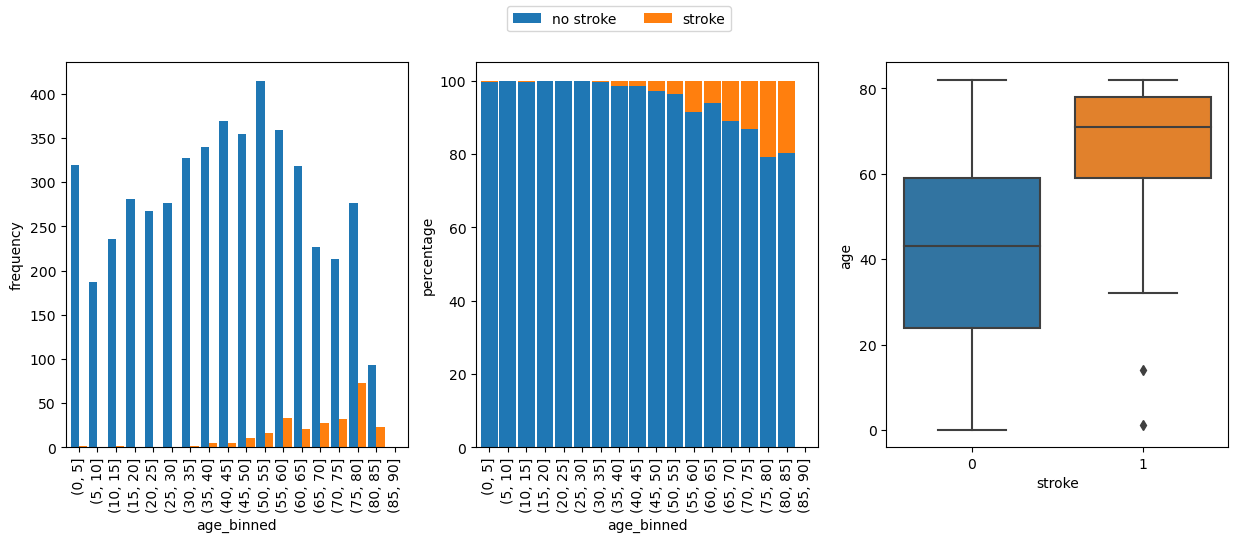

In [18]:
# Age
get_charts("age_binned")
plt.show()

Age strongly affects stroke conditions when seniors have higher stroke cases and stroke ratio. The stroke trend starts to increase dramatically after 35 years old. Most of the people suffering from stroke are greater than 70. There are some outliers, but it is not many. <br>

Although `age` is highly correlated with other independent features, it seems to be potentially significant in predicting `stroke`.


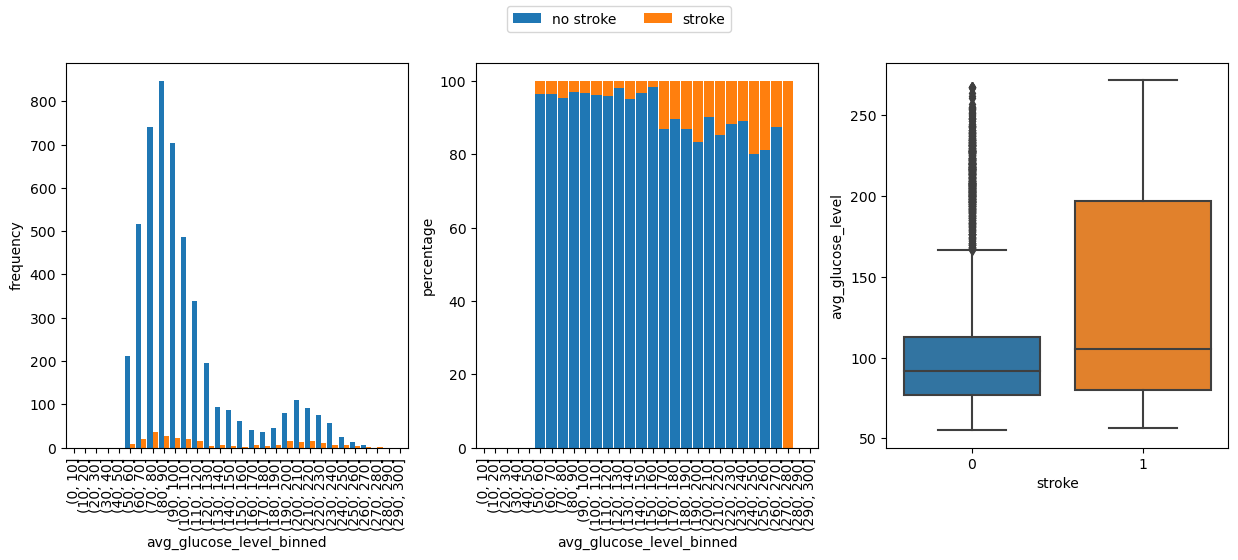

In [19]:
# Average glucoser level
get_charts("avg_glucose_level_binned")
plt.show()

The first chart shows the distribution by average glucose level, with many observations in the range of [60,110]. The second plot indicates the stroke ratio increases when the glucose level increases. Again in the third chart, stroke cases have a higher variance, with most cases having sugar levels greater than 100.


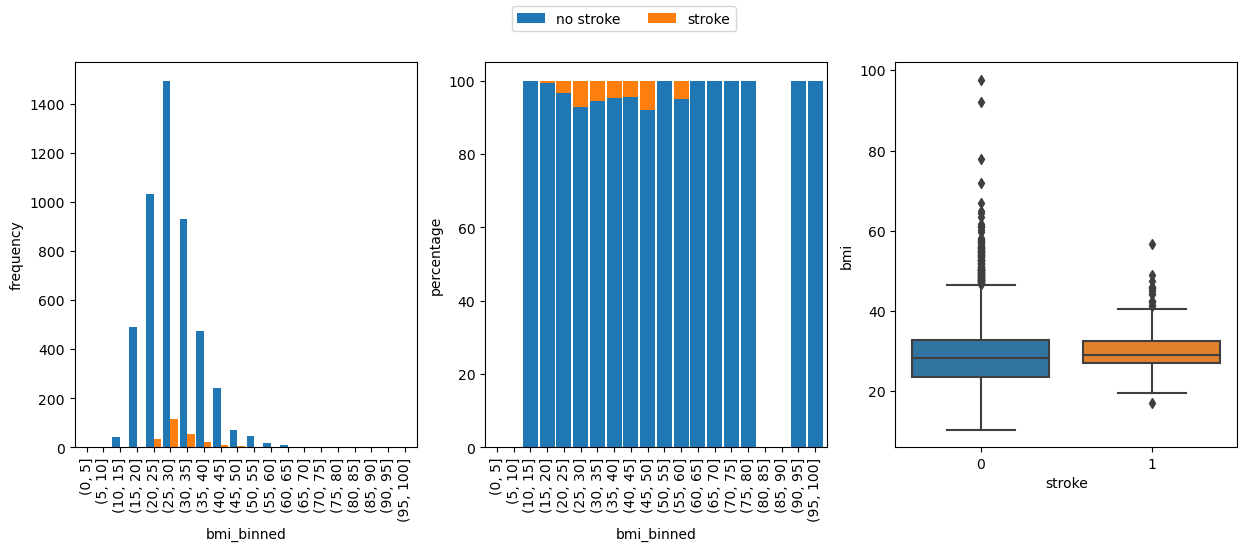

In [20]:
# BMI
get_charts("bmi_binned")
plt.show()

There are not many cases that have significantly high `bmi`; hence the percentage chart gets some missing values. Most cases are in the range [15,40]. In contrast with the sugar level, the variance of stroke cases is less than the normal cases, focusing on groups 25-30. <br>

Getting visualisation of categorical variables


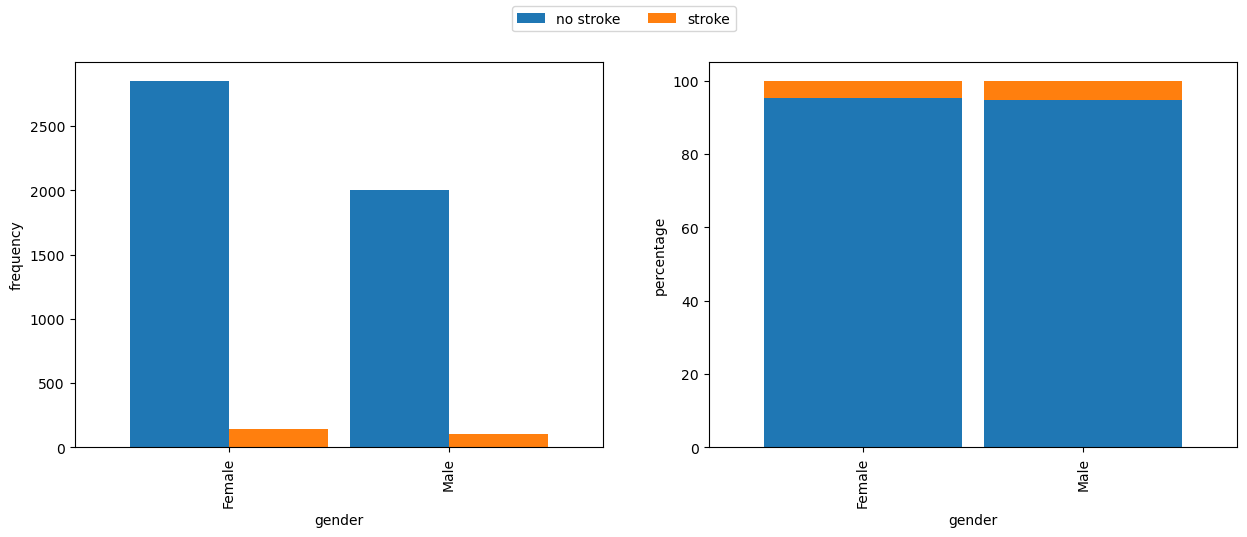

In [21]:
# Gender
get_charts("gender", type="categorical")
plt.show()

There is no significant difference between the 2 genders in terms of stroke conditions.

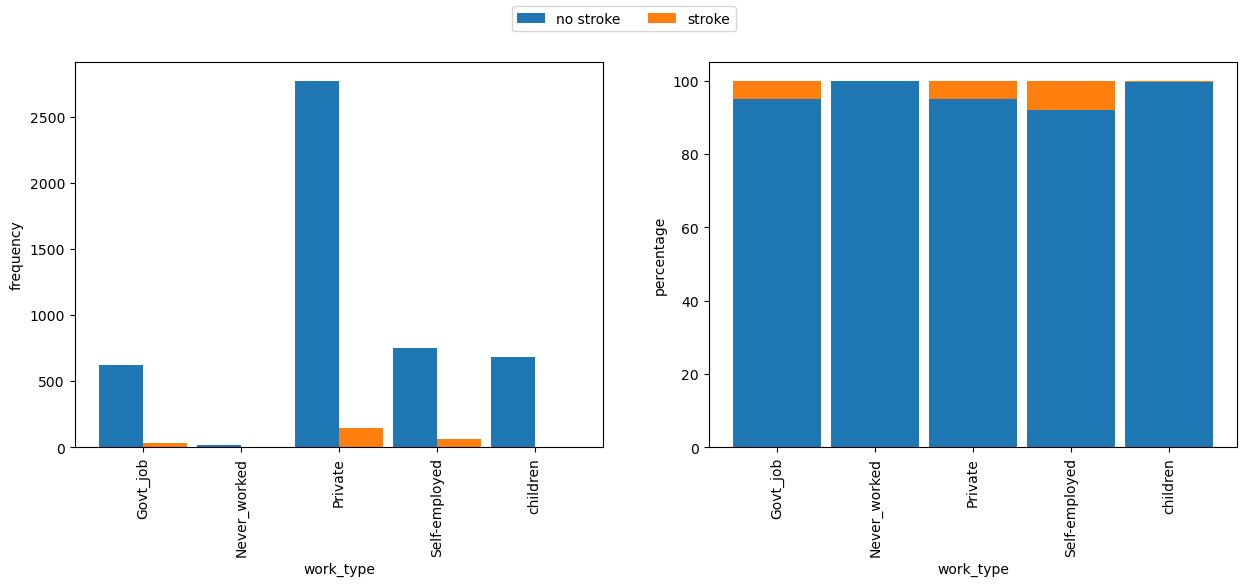

In [22]:
#Worktype
get_charts("work_type", type="categorical")
plt.show()

The dataset has the most stroked cases in private work type but the highest stroke ratio belongs to business owner groups. People working for governments are in the thread of stroke as well.

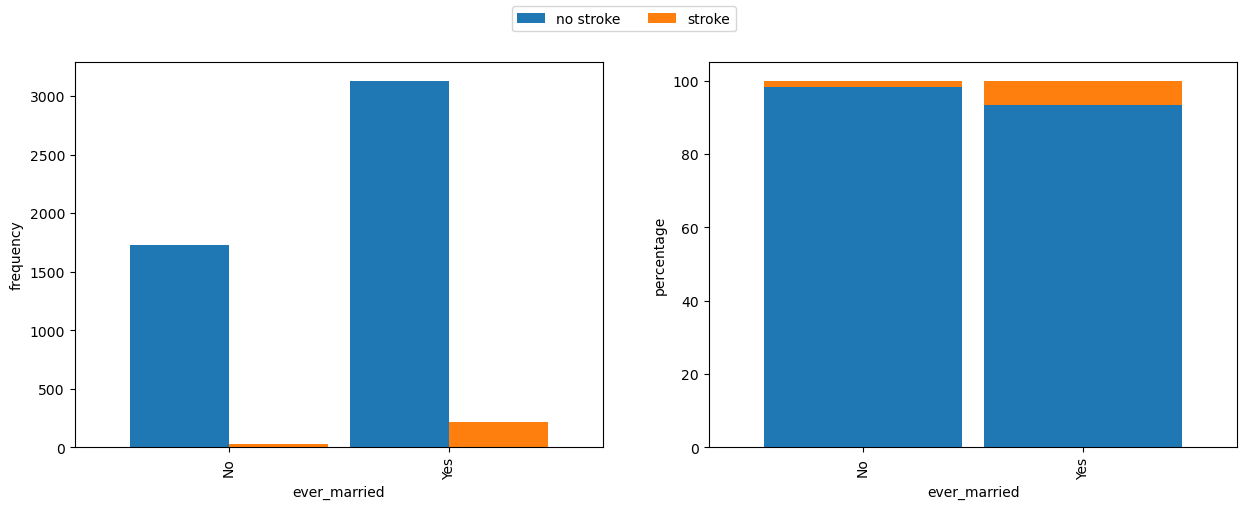

In [23]:
#Ever_married
get_charts("ever_married", type="categorical")
plt.show()

Obviously, married people have a high stroke percentage which may be explained by the stress of marriage and the relation with age features (mentioned in the heatmap). Therefore, we need to run regression models to define significance for more accuracy.

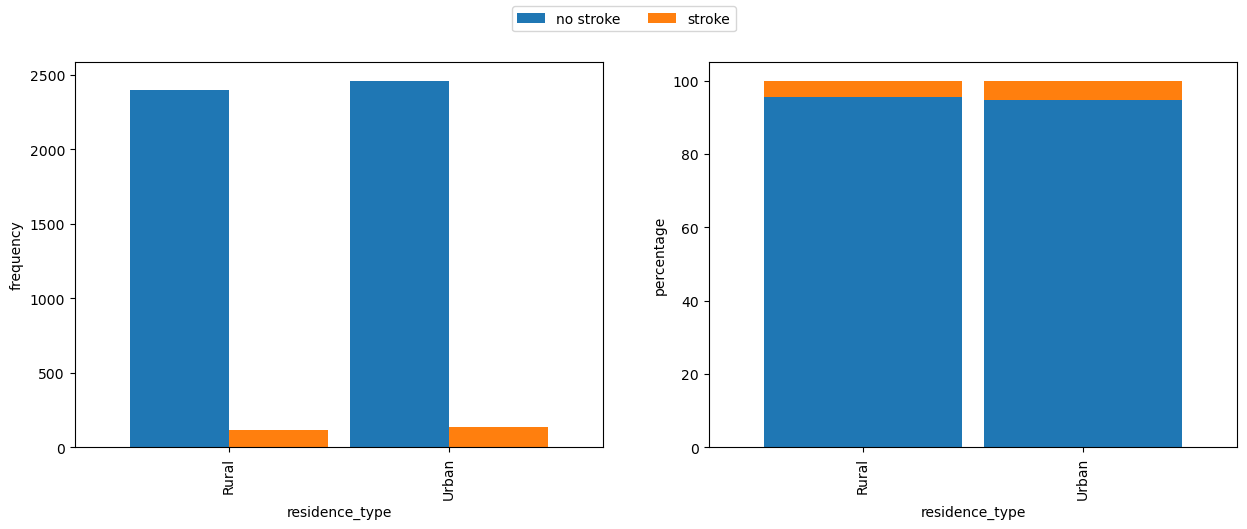

In [24]:
#Residence type
get_charts("residence_type", type="categorical")
plt.show()

The places seem to be not much related to stroke.

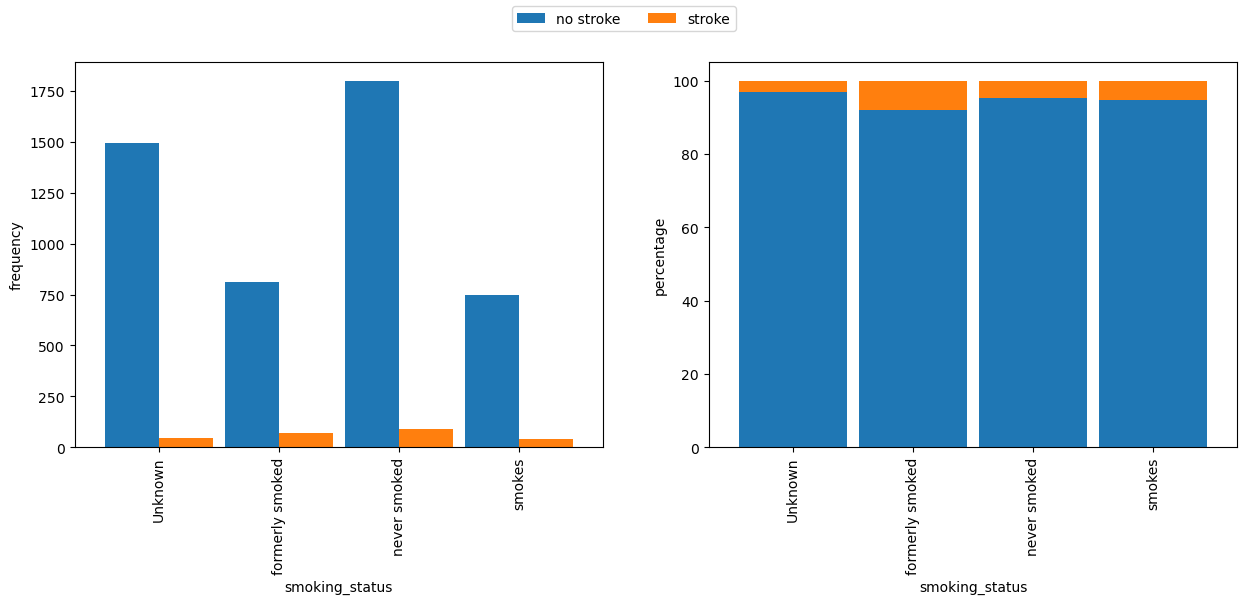

In [25]:
#Smoking status
get_charts("smoking_status", type="categorical")
plt.show()

People who quit smoking usually suffer a high thread of stroke. It may be explained by the old persons tends to quit smoking and the effect of age, which makes the stroke ratio goes high (mentioned in the heatmap).

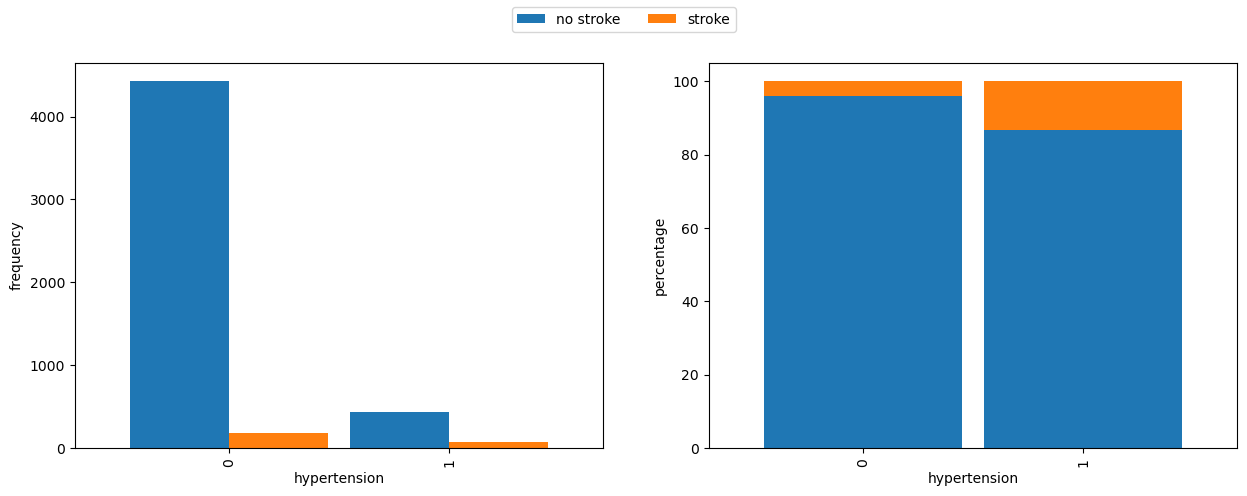

In [26]:
# Hypertension
get_charts("hypertension", type="categorical")
plt.show()

The distribution is an imbalance with more positive cases in a group of people with no hypertension but in the second chart, stroke appears in persons with hypertension more often than without it.

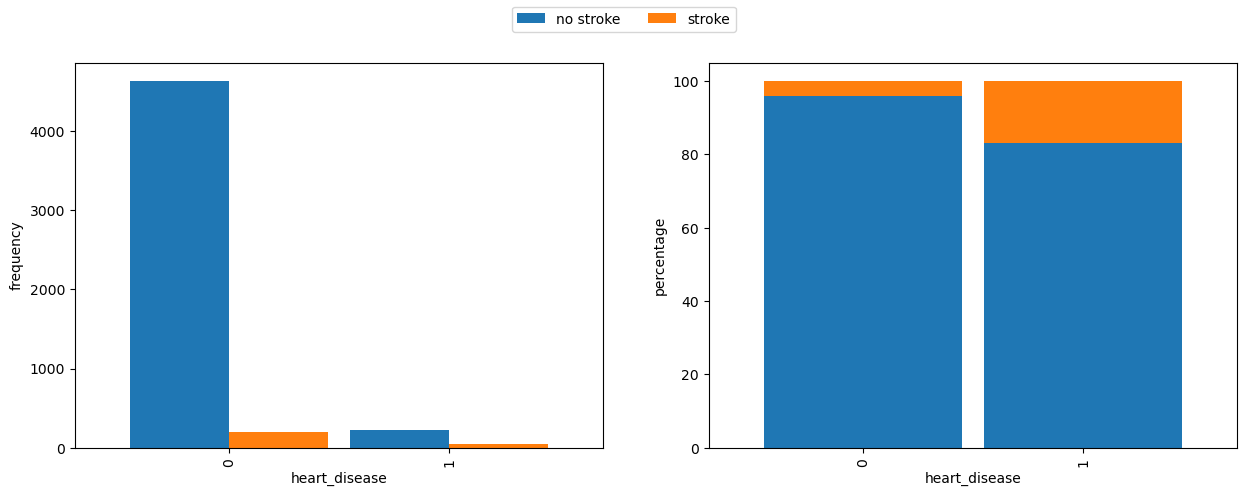

In [27]:
#Heart disease
get_charts("heart_disease", type="categorical")
plt.show()

It shows the same pattern with the feature `hypertension` but has higher level differences in the 2 groups of stroke.

## Modeling

### Balance the dataset

To balance data, SMOTE model generates synthetic data based on the distribution of training and testing set


In [28]:
# Split dataset
train_x_full, test_x_full, train_y, test_y = train_test_split(
    X,
    y,
    random_state=1255,
    test_size=0.25
)

# Get SMOTE model and generate synthetic data
smote = SMOTE()
train_x_full, train_y = smote.fit_resample(train_x_full, train_y)
test_x_full, test_y = smote.fit_resample(test_x_full, test_y)

# Print out size of new datasets
print(
    train_x_full.shape,
    train_y.shape,
    test_x_full.shape,
    test_y.shape
)

(7294, 15) (7294,) (2426, 15) (2426,)


### Fit model

For testing and evaluating different models eassier, 2 functions are defined: 1 for plot ROC curves and 1 for prediction and evaluation.

In [29]:
# ROC ploting function
def plot_roc_curve(true_y, y_prob, auc, type):
    # Plot the roc curve based of the probabilities
    fpr, tpr, _ = roc_curve(true_y, y_prob[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(label="Model %s (AUC: %s)" % (type, auc))
    return None

# Test and evaluation model function
def test_model(m_dict):
    # Declare variables
    type = m_dict["type"]
    model = m_dict["model"]
    y_train = train_y
    y_test = test_y
    x_train = train_x_full.drop(m_dict["removed_features"], axis=1)
    x_test = test_x_full.drop(m_dict["removed_features"], axis=1)
    # Train model and get predictions
    clf = model.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_proba = clf.predict_proba(x_test)
    # Compute evaluation metrics
    scores = cross_val_score(clf, x_train, y_train, cv=10)
    accuracy_mean = scores.mean()
    cfm = pd.crosstab(
        y_test,
        y_pred,
        rownames=['Actual'],
        colnames=['Predicted'])
    auc = round(roc_auc_score(y_test, y_pred), 3)
    # Print out results
    print("-----------Model: %s ------------" % type)
    print(" ")
    print("K-Fold Validation Mean Accuracy: %s " % accuracy_mean)
    print(" ")
    print("Confusion matrix: \n %s " % cfm)
    print(" ")
    print("Evaluation metrics: \n %s " % classification_report(y_test, y_pred))
    # Get ROC plot for model
    roc = plot_roc_curve(y_test, y_proba, auc, type)
    plt.show()
    return y_pred, accuracy_mean, cfm, auc, roc

The testing function takes model types, model initiation and desired removed features (if not, use the empty list []) as an argument dictionary to return predictions, accuracy mean of cross-validation with k = 10, confusion matrix, AUC values and ROC curves.

#### Logistic Regression

Due to the dependent variable being binary variables, logistic regression is suitable, but it needs to check with the assumptions of the regression model. As explored above, there are some highly correlated features needed to be addressed, so this stage includes assumption checking and feature selection by using the `GLM()` function. <br>

Basic assumptions of logistic regression: linearity in the logit for continuous variables, independence of errors, absence of multicollinearity, and lack of strongly influential outliers. (Note: The multicollinearity mentioned in the correlation analysis above.)


In [30]:
res = GLM(
    train_y,
    train_x_full,
    family=families.Binomial(),
).fit(random_state=0)

The linearity assumption is checked by visualisation of continuous features with the log odds.

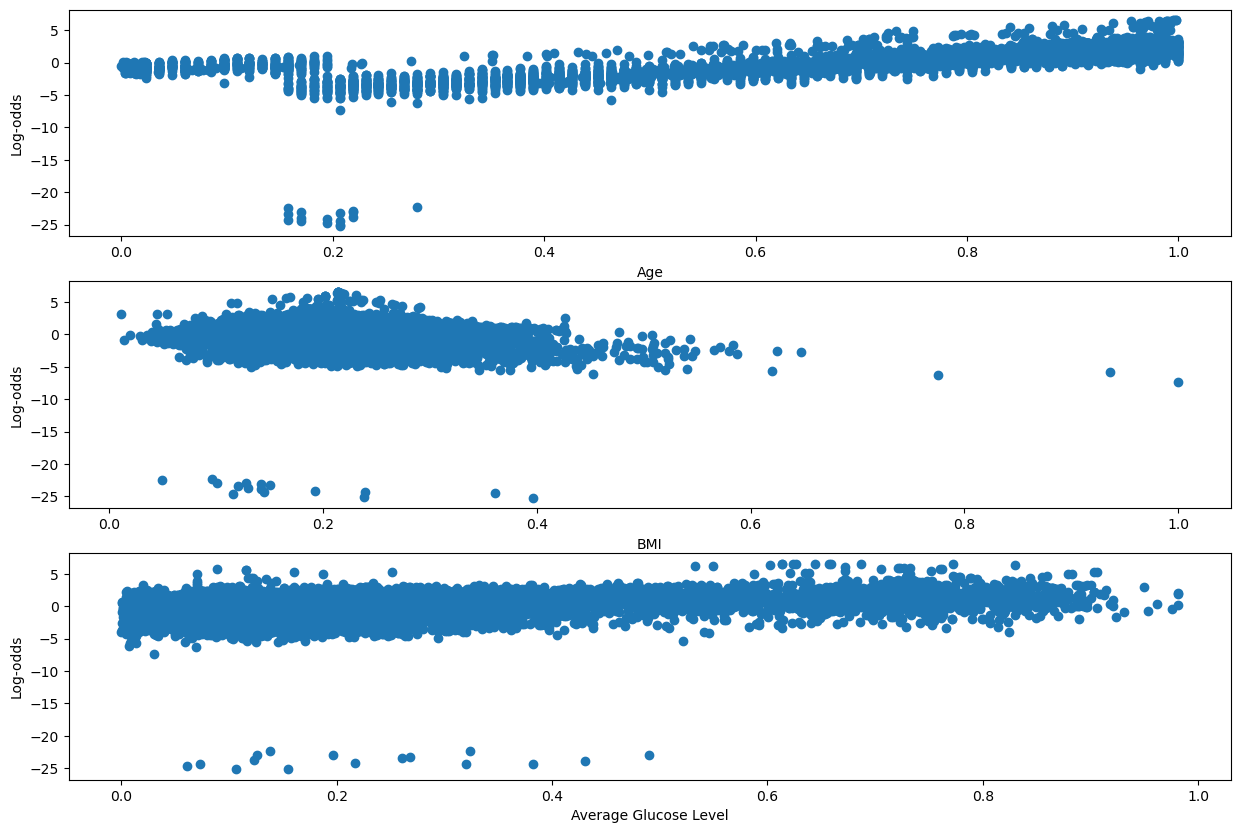

In [31]:
# ASSUMPTION: Linearity logit relation
pred_x= res.predict(train_x_full)
# Getting log odds values
log_odds = np.log(pred_x / (1 - pred_x))
# Visualize predictor variable vs logit values for Age
fig, (ax1,ax2,ax3) = plt.subplots(nrows = 3, figsize = (15,10))
ax1.scatter(x=train_x_full['age_norm'].values, y=log_odds)
ax2.scatter(x=train_x_full['bmi_norm'].values, y=log_odds)
ax3.scatter(x=train_x_full['avg_glucose_level_norm'].values, y=log_odds)
ax1.set_xlabel("Age")
ax1.set_ylabel("Log-odds")
ax2.set_xlabel("BMI")
ax2.set_ylabel("Log-odds")
ax3.set_xlabel("Average Glucose Level")
ax3.set_ylabel("Log-odds")
plt.show()

It is clear that all continuous variables have a linear relation with the log odds. <br>

There are many indexes for checking influential points, and in this case, we use Cook's Distance (a measure of the simultaneous change in the parameter estimates when an observation is deleted from the analysis) and Standardised Residuals (residuals divided by their standard errors). Computing these metrics for each observation and checking whether they exceed the threshold. All observations that exceed the threshold are influential points.


In [32]:
# ASSUMPTION:Influential points
infl = res.get_influence(observed=False)
summ_df = infl.summary_frame()
cook_threshold = 4 / len(train_x_full)
summ_df['standard_resid'] = summ_df['standard_resid'].apply(lambda x: np.abs(x))
summ_df[(summ_df['cooks_d'] > cook_threshold) & (summ_df['standard_resid']>3)]

,dfb_age_norm,dfb_avg_glucose_level_norm,dfb_bmi_norm,dfb_gender_Female,dfb_work_type_Govt_job,dfb_work_type_Never_worked,dfb_work_type_Private,dfb_work_type_Self-employed,dfb_ever_married_Yes,dfb_residence_type_Rural,dfb_smoking_status_formerly smoked,dfb_smoking_status_never smoked,dfb_smoking_status_smokes,dfb_hypertension_1,dfb_heart_disease_1,cooks_d,standard_resid,hat_diag,dffits_internal
3,-0.013799,-0.045886,0.014178,0.023452,0.008551,2.231885e-09,0.012292,-0.006776,-0.002035,0.036631,-0.036958,0.009995,0.005069,-0.059458,0.024160,0.001011,3.798432,0.001050,-0.123136
33,-0.081765,0.017753,0.026871,0.036520,0.036308,-6.900455e-09,0.027300,0.042317,0.003002,0.031597,0.008810,0.007475,-0.067492,0.024007,0.034528,0.001061,4.538120,0.000772,-0.126173
34,-0.044899,-0.010644,0.019982,0.038821,-0.012939,8.019959e-09,0.024584,0.027362,-0.002088,0.026292,-0.045190,-0.003975,-0.005823,0.012278,0.024450,0.000881,3.486523,0.001085,-0.114932
96,-0.046934,-0.010481,0.010397,0.048872,-0.005633,8.779828e-08,0.030116,0.032076,-0.005100,0.028210,-0.001836,-0.032599,-0.004349,0.021705,0.023199,0.000806,3.222831,0.001162,-0.109934
176,-0.024413,-0.023170,0.043350,0.028566,-0.041233,-1.820368e-07,-0.009015,-0.000454,-0.023005,0.025424,0.034198,0.048702,0.033198,-0.072229,0.024091,0.001232,3.775219,0.001295,-0.135925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6606,-0.037647,-0.041310,0.043321,0.031983,-0.001083,-2.642713e-08,0.004488,0.001749,0.007704,0.037814,-0.000754,-0.000170,0.063044,-0.001136,0.007492,0.000903,4.313980,0.000728,0.116406
6846,-0.038142,-0.014671,0.003049,0.035331,0.013305,3.982204e-08,0.020754,0.015838,0.009384,0.038952,0.000678,-0.001438,0.061999,-0.002546,0.002037,0.000721,3.522176,0.000871,0.103976
6861,-0.036734,-0.016656,-0.000941,0.035280,0.014467,5.173638e-08,0.022096,0.016669,0.009776,0.039193,0.001050,-0.001386,0.062113,-0.002310,0.002095,0.000721,3.432990,0.000917,0.103978
7098,-0.039379,-0.014956,0.003125,0.035616,0.014074,4.201242e-08,0.021560,0.016666,0.009608,0.039279,0.000831,-0.001268,0.062180,-0.002298,0.002371,0.000732,3.604335,0.000845,0.104820


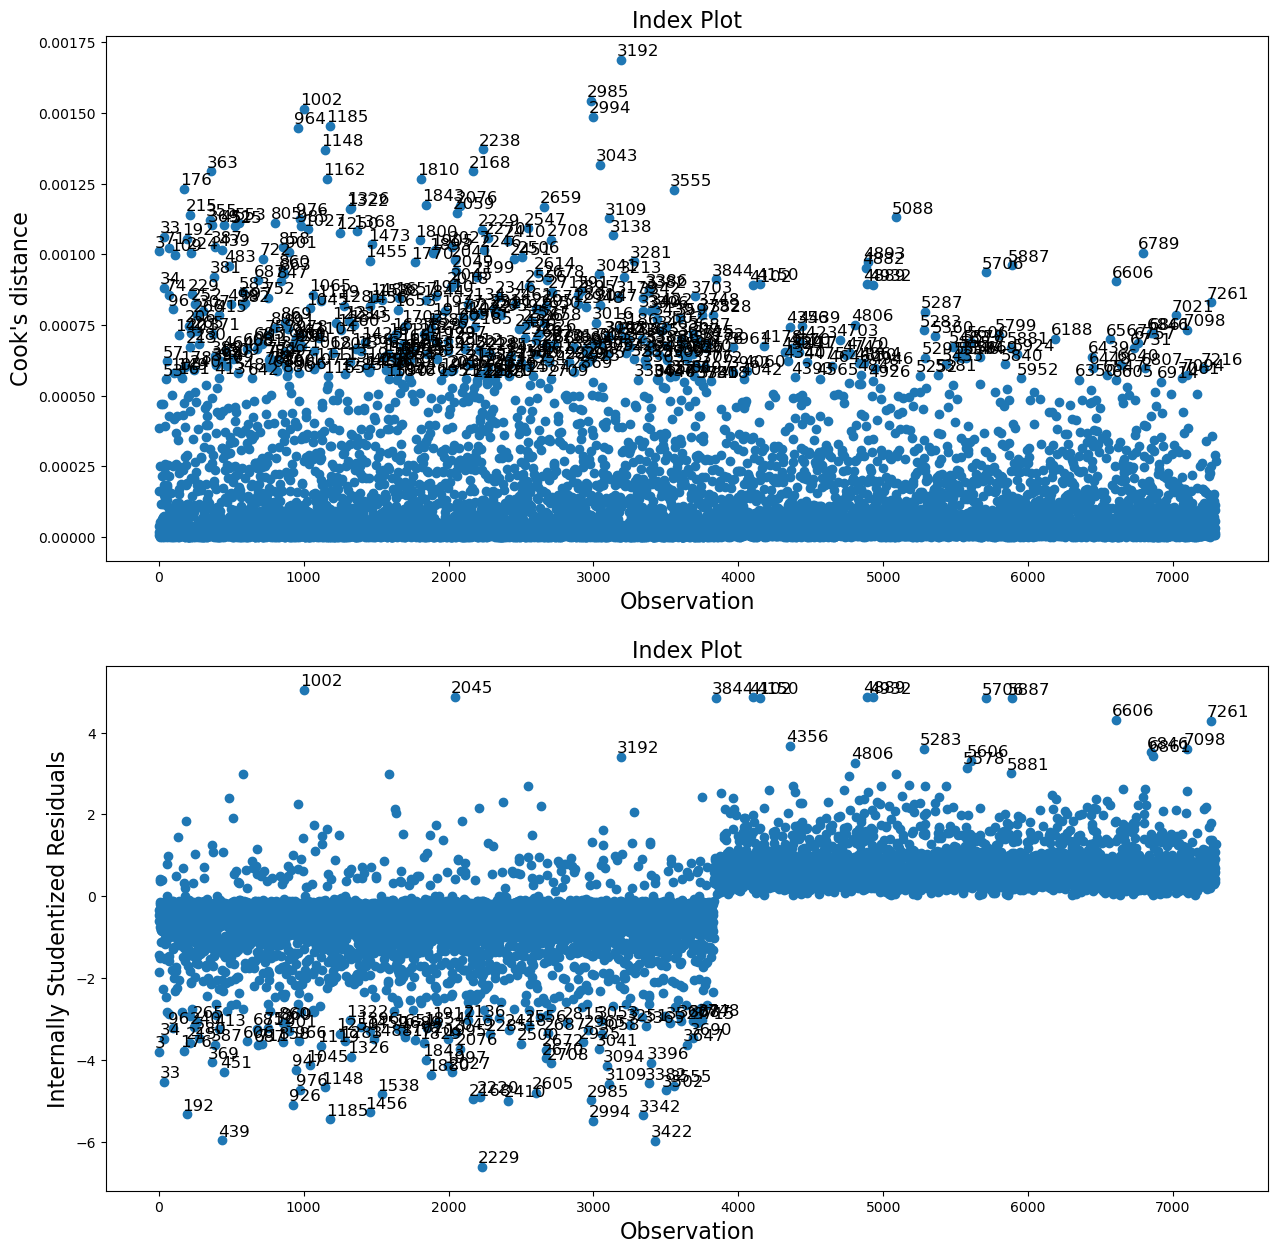

In [33]:
# For  visualisation
fig, (ax1,ax2) = plt.subplots(nrows=2,figsize = (15,15))
infl.plot_index(y_var='cooks', 
                threshold=cook_threshold,
                ax=ax1)
infl.plot_index(y_var='resid', 
                threshold=3,
                ax = ax2)
#fig.tight_layout(pad=1.0)
plt.show()

Only 111 cases are outside the thresholds of Cook's Distance and standardised residuals. It is less than 5% of the number of cases (5%\*7294 = 365), so the influential points may not cause any problems with the model. The assumption is satisfied. <br>

The independence of error terms is validated by checking the chart of residuals and their order. If there are any special patterns that means observations, errors are linked to each other


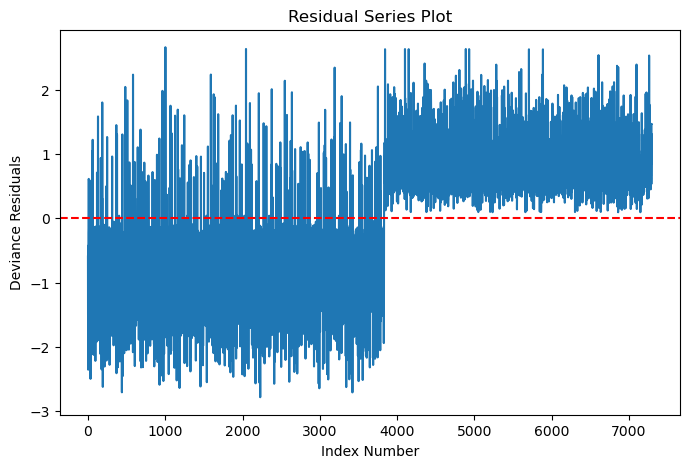

In [34]:
# ASSUMPTION : Independence of errors
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
                     xlabel="Index Number", 
                     ylabel="Deviance Residuals")
# Generate residual series plot using standardized deviance residuals
ax.plot(train_x_full.index.tolist(), stats.zscore(res.resid_deviance))
# Draw horizontal line at y=0
plt.axhline(y = 0, ls="--", color='red')
plt.show()

The plot shows random errors. After nearly the first 4000 observations, the residuals increased, and it is explained by the synthetic data giving higher errors. However, generally, it still is scattered randomly. <br>

Next is the feature selection.

In [35]:
# Summary the logistic regression model
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                 7294
Model:                            GLM   Df Residuals:                     7279
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3483.1
Date:                Mon, 20 Mar 2023   Deviance:                       6966.3
Time:                        01:19:21   Pearson chi2:                 7.38e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.3503
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
age_norm    

`work_type_Never_worked`, `ever_married_Yes` and `hypertension_1` are not significant in stroke predictions.

In [36]:
#Removed column names
removed_features = ['work_type_Never_worked', 'ever_married_Yes','hypertension_1']
# Remove columns and fit again
res = GLM(
    train_y,
    train_x_full.drop(removed_features, axis=1),
    family=families.Binomial(),
).fit(random_state=0)
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                 7294
Model:                            GLM   Df Residuals:                     7282
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3496.4
Date:                Mon, 20 Mar 2023   Deviance:                       6992.7
Time:                        01:19:22   Pearson chi2:                 7.44e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3479
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
age_norm    

All variables are significant now. Although the good fit of the model is slightly decreased model only runs 6 iterations to converge. It helps save sources (time, memory) and avoid overfitting. <br>

`LogisticRegression()` is a model initiation and is stored inside a dictionary with the type and list of removed features.

In [37]:
logit_dict = {
    "type": "Logistic Regression",
    "model": LogisticRegression(),
    "removed_features": removed_features
}

Using the testing function to get prediction and all evaluation metrics.

-----------Model: Logistic Regression ------------
 
K-Fold Validation Mean Accuracy: 0.7977807843358324 
 
Confusion matrix: 
 Predicted    0    1
Actual             
0          929  284
1          220  993 
 
Evaluation metrics: 
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      1213
           1       0.78      0.82      0.80      1213

    accuracy                           0.79      2426
   macro avg       0.79      0.79      0.79      2426
weighted avg       0.79      0.79      0.79      2426
 


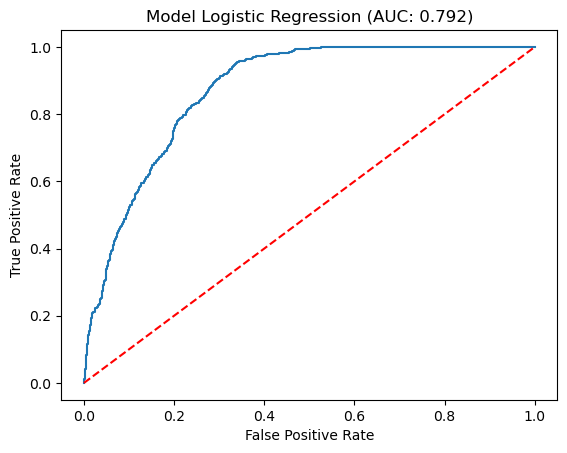

In [38]:
y_pred, accuracy_mean, cfm, auc, roc = test_model(logit_dict)

#### XGBoost

XGBoost stands for Extreme Gradient Boosting. It is an alrothism in boosting essemble method where fit models iteratively and update the current model with the opposite of the gradient of fitting error (e.g. pseudo-residuals).

Creating an XGBoost model, using feature selections with `BoostRFE`, storing all required data inside a dictionary and testing with the function


-----------Model: XGBoost ------------
 
K-Fold Validation Mean Accuracy: 0.9525790630813462 
 
Confusion matrix: 
 Predicted     0     1
Actual               
0          1163    50
1           210  1003 
 
Evaluation metrics: 
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      1213
           1       0.95      0.83      0.89      1213

    accuracy                           0.89      2426
   macro avg       0.90      0.89      0.89      2426
weighted avg       0.90      0.89      0.89      2426
 


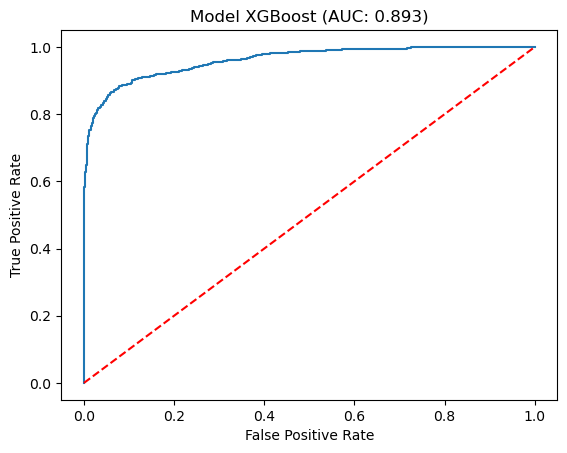

In [39]:
# Create model & select features.
xg = xgb.XGBClassifier(random_state=0)
#xg_rfe = BoostRFE(xg) 
#xg_rfe.fit(train_x_full, train_y)
#removed_features = [k for k, v in zip(train_x_full.columns, xg_rfe.ranking_) if v != 1]

# Store info
xg_dict = {
    "type": "XGBoost",
    "model": xg,
    "removed_features": []
}

# Test model 
y_pred, accuracy_mean, cfm, auc, roc = test_model(xg_dict)

The XGBoost model (accuracy ~ 88.5%) performs better than the logistic regression (accuracy ~ 80%) in this case. <br> The XGBoost model can reach accuracy up to 94% when using BoostRFE to select features.

# References: 
<https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290#293b>

<https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8>

<https://www.analyticsvidhya.com/blog/2021/05/how-to-create-a-stroke-prediction-model/>